Unexpected shape at trial 269: (727, 22)
Original signal shape: (269, 750, 22)
Labels shape: (269,)
Number of unique labels: 4
Extracting features using FFT...
Features shape: (269, 110)
Normalized features shape: (269, 110)
Labels shape: (269,)
Training samples: 215, Testing samples: 54
Tuning SVM parameters...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Training final model...
Accuracy: 0.4074

Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.54      0.47        13
           1       0.23      0.21      0.22        14
           2       0.80      0.62      0.70        13
           3       0.29      0.29      0.29        14

    accuracy                           0.41        54
   macro avg       0.43      0.41      0.42        54
weighted avg       0.43      0.41      0.41        54



<Figure size 1000x800 with 0 Axes>

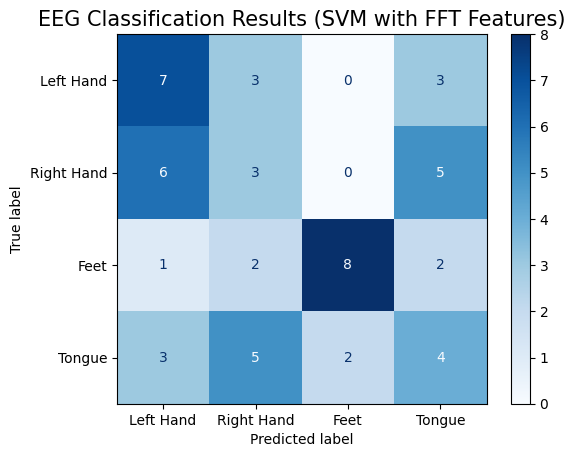

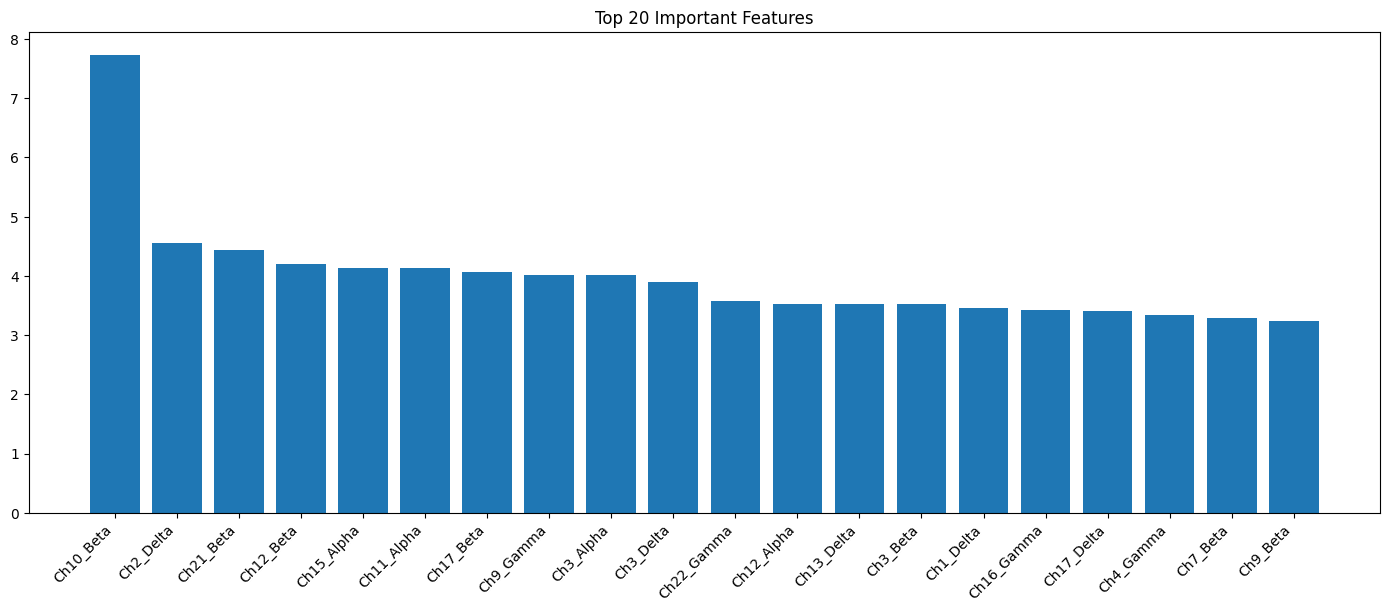

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc
from scipy.fftpack import fft  # Using SciPy's FFT (faster than NumPy's)

# ----- 1. Load and prepare data -----
data = np.load('A02T.npz')  
eeg_signal = data['s']  # Using eeg_signal instead of signal to avoid name conflict
event_types = data['etyp'].T[0]
event_positions = data['epos'].T[0]

# Initialize empty arrays
signals = []
trial_types = []
valid_labels = {769, 770, 771, 772}

# Extract trials
for i in range(0, len(event_positions) - 1):
    event_type = event_types[i]
    next_event_type = event_types[i + 1]
    
    if event_type == 768 and next_event_type in valid_labels:  # Valid trial start
        pos = event_positions[i+1]
        
        # Extract 750 samples x 22 channels
        trial_signal = eeg_signal[pos+750 : pos+1500, 0:22]  # All 22 channels
        
        # Verify the shape is correct
        if trial_signal.shape != (750, 22):
            print(f"Unexpected shape at trial {len(signals)}: {trial_signal.shape}")
            continue
            
        signals.append(trial_signal)
        trial_types.append(next_event_type)

# Convert to numpy arrays
signals_array = np.array(signals)
labels_array = np.array(trial_types)

# Map labels to 0-3
label_mapping = {769: 0, 770: 1, 771: 2, 772: 3}
y = np.array([label_mapping[int(x)] for x in labels_array])

# Display data shapes for verification
print("Original signal shape:", signals_array.shape)
print("Labels shape:", y.shape)
print("Number of unique labels:", len(np.unique(y)))

# ----- 2. Simple feature extraction using built-in FFT -----
def extract_band_powers(trial_data, fs=250):
    """
    Extract frequency band powers for all channels in a trial.
    trial_data: shape (time_samples, channels)
    
    Returns a feature vector with band powers for each channel.
    """
    # Define frequency bands
    bands = {
        'delta': (1, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    # Number of samples per trial
    n_samples = trial_data.shape[0]
    
    # Compute frequency resolution
    freq_resolution = fs / n_samples
    
    # Create frequency bins
    freqs = np.fft.fftfreq(n_samples, 1/fs)
    
    # Find indices for positive frequencies only
    pos_freq_idx = freqs >= 0
    
    # Initialize feature vector
    features = []
    
    # For each channel
    for ch in range(trial_data.shape[1]):
        # Apply Hamming window to reduce spectral leakage
        windowed_signal = trial_data[:, ch] * np.hamming(n_samples)
        
        # Compute FFT
        fft_values = fft(windowed_signal)
        
        # Compute power spectrum (take only positive frequencies)
        power_spectrum = np.abs(fft_values[pos_freq_idx])**2
        pos_freqs = freqs[pos_freq_idx]
        
        # Extract band powers
        for band_name, (low_freq, high_freq) in bands.items():
            # Find frequencies within band
            band_idx = np.logical_and(pos_freqs >= low_freq, pos_freqs <= high_freq)
            
            # Compute mean power in band
            if np.any(band_idx):
                band_power = np.mean(power_spectrum[band_idx])
            else:
                band_power = 0
                
            features.append(band_power)
    
    return np.array(features)

# Extract features for all trials
print("Extracting features using FFT...")
features = []

for i in range(signals_array.shape[0]):
    trial_features = extract_band_powers(signals_array[i])
    features.append(trial_features)

features = np.array(features)
print("Features shape:", features.shape)

# ----- 3. Handle potential mismatch between features and labels -----
if features.shape[0] != y.shape[0]:
    print(f"WARNING: Feature count ({features.shape[0]}) doesn't match label count ({y.shape[0]})")
    
    # Calculate the ratio
    ratio = features.shape[0] // y.shape[0]
    
    if ratio > 1 and features.shape[0] % y.shape[0] == 0:
        print(f"Detected {ratio} features per label. Combining features...")
        
        # Reshape features to group them by label
        grouped_features = features.reshape(y.shape[0], ratio, -1)
        
        # Average the features for each label
        features = np.mean(grouped_features, axis=1)
        print(f"Combined features shape: {features.shape}")
    else:
        print("Cannot automatically resolve mismatch. Please check your data preprocessing.")
        raise ValueError("Feature and label counts don't match and can't be automatically resolved")

# ----- 4. Normalize features -----
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)
print("Normalized features shape:", features_normalized.shape)
print("Labels shape:", y.shape)

# ----- 5. Split data for training and testing -----
X_train, X_test, y_train, y_test = train_test_split(
    features_normalized, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ----- 6. Parameter tuning with grid search -----
print("Tuning SVM parameters...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01],
    'kernel': ['rbf', 'linear']
}

grid_search = GridSearchCV(
    SVC(probability=True), 
    param_grid, 
    cv=5, 
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")

# ----- 7. Train final model with best parameters -----
print("Training final model...")
svm = grid_search.best_estimator_
svm.fit(X_train, y_train)

# ----- 8. Evaluate model performance -----
# Predictions
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# ----- 9. Visualize results -----
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
class_names = ['Left Hand', 'Right Hand', 'Feet', 'Tongue']

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title('EEG Classification Results (SVM with FFT Features)', fontsize=15)
plt.savefig('svm_confusion_matrix.png')
plt.show()

# Feature importance visualization (for linear kernel only)
if svm.kernel == 'linear':
    plt.figure(figsize=(14, 6))
    # Get feature importance from SVM coefficients
    importance = np.abs(svm.coef_).mean(axis=0)
    # Create feature names
    bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']
    feature_names = [f'Ch{ch+1}_{band}' for ch in range(22) for band in bands]
    
    # Sort by importance
    indices = np.argsort(importance)[::-1]
    # Plot top 20 features
    plt.bar(range(20), importance[indices[:20]])
    plt.xticks(range(20), [feature_names[i] for i in indices[:20]], rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Top 20 Important Features')
    plt.savefig('feature_importance.png')
    plt.show()
